## Importing Standard Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

## EDA

### Reading The Data and Checking Shape

In [2]:
dfc = pd.read_csv("airqual.csv")
dfc.shape

(9357, 15)

### Checking Basic Stats of The Columns And Their Datatypes

In [3]:
dfc['Date'] = dfc['Date'].astype('object')
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [4]:
dfc.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


### Handling Error Values

In [5]:
dfc.replace(to_replace = -200, value = np.NaN , inplace = True )
num = dfc.isnull().sum()
percent = num/dfc.shape[0]*100
percent

Date              0.000000
Time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64

### Handling Date and Time Column

In [6]:
dfc['DateTime'] = dfc['Date'] + ' ' + dfc['Time']
dfc.drop(['Time'], axis=1, inplace=True)
dfc['DateTime'] = pd.to_datetime(dfc['DateTime'].astype(str))
dfc['Date'] = pd.to_datetime(dfc['Date'].astype(str), format='%d-%m-%Y')
dfc.head()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,2004-03-10,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-10-03 18:00:00
1,2004-03-10,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-10-03 19:00:00
2,2004-03-10,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-10-03 20:00:00
3,2004-03-10,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-10-03 21:00:00
4,2004-03-10,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-10-03 22:00:00


### Handling NA Values

In [7]:
num = dfc.isnull().sum()
percent = num/dfc.shape[0]*100
percent

Date              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
DateTime          0.000000
dtype: float64

### Dropping Unnecessary Columns and Replacing Rest Of the NA Values by Mean or Mode

In [8]:
dfc.drop(['NMHC(GT)'], axis= 1, inplace= True)
num = dfc.isnull().sum()
percent = num/dfc.shape[0]*100
percent

Date              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
DateTime          0.000000
dtype: float64

In [9]:
dfc["T"] = dfc.groupby("Date")["T"].transform(lambda x: x.fillna(x.mean()))
dfc["CO(GT)"] = dfc.groupby("Date")["CO(GT)"].transform(lambda x: x.fillna(x.mean()))
dfc["NOx(GT)"] = dfc.groupby("Date")["NOx(GT)"].transform(lambda x: x.fillna(x.mean()))
dfc["NO2(GT)"] = dfc.groupby("Date")["NO2(GT)"].transform(lambda x: x.fillna(x.mean()))

In [10]:
num = dfc.isnull().sum()
percent = num/dfc.shape[0]*100
percent

Date             0.000000
CO(GT)           9.233729
PT08.S1(CO)      3.911510
C6H6(GT)         3.911510
PT08.S2(NMHC)    3.911510
NOx(GT)          8.720744
PT08.S3(NOx)     3.911510
NO2(GT)          8.720744
PT08.S4(NO2)     3.911510
PT08.S5(O3)      3.911510
T                2.051940
RH               3.911510
AH               3.911510
DateTime         0.000000
dtype: float64

### Visualizing The NA Values

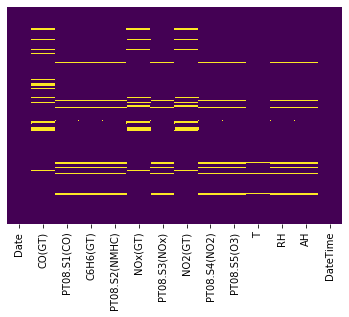

In [11]:
sns.heatmap(dfc.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Filling All The Remaing NA Values

In [12]:
dfc.fillna(method='ffill', inplace= True)
num = dfc.isnull().sum()
percent = num/dfc.shape[0]*100
percent

Date             0.0
CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
DateTime         0.0
dtype: float64

## Visualizations

### Checking The Distribution Of All Variables With Respect To Date

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8e19831d0>,
      dtype=object)

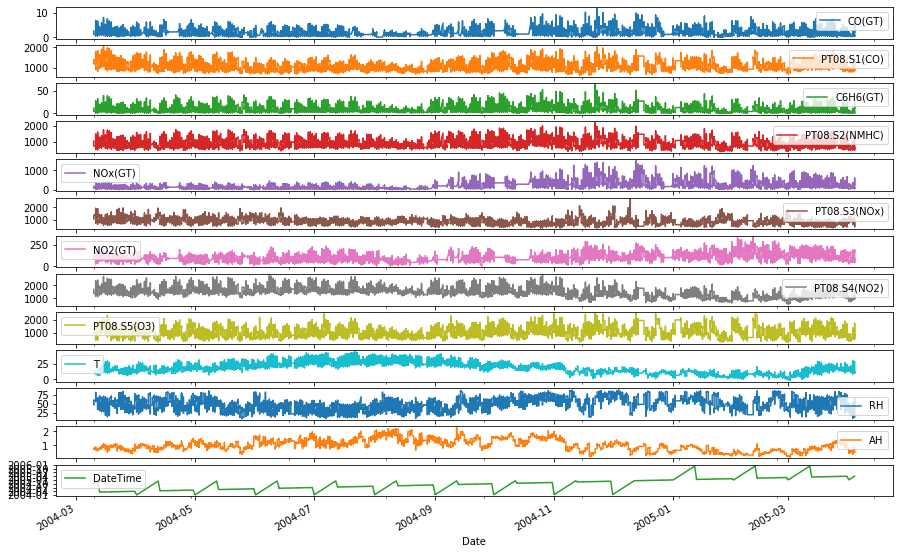

In [13]:
dfc.plot(x = 'Date', subplots = True, figsize = (15, 10), legend = True)

### Distribution Of CO(GT) with Date

<Figure size 432x288 with 0 Axes>

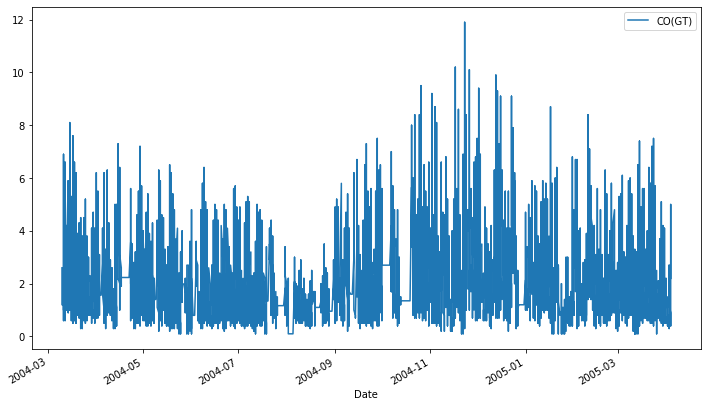

In [14]:
plt.figure(); 
dfc.plot(x = 'Date', y = 'CO(GT)', figsize = (12, 7));
plt.legend(loc = 'best')

### Distribution Of CO(GT)

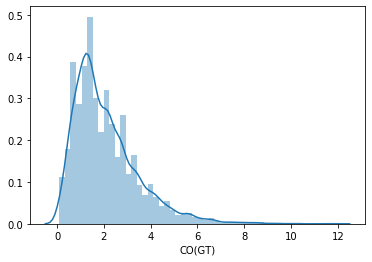

In [15]:
sns.distplot(dfc["CO(GT)"])

### Distribution Of NOx(GT)

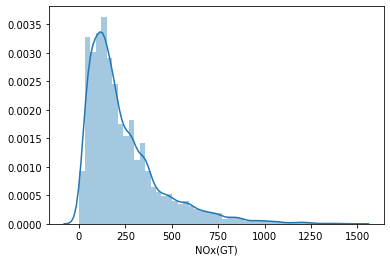

In [16]:
sns.distplot(dfc["NOx(GT)"])

### Distribution Of N02(GT)

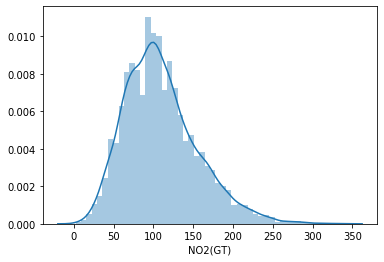

In [17]:
sns.distplot(dfc["NO2(GT)"])

### Distribution Of C6H6(GT)

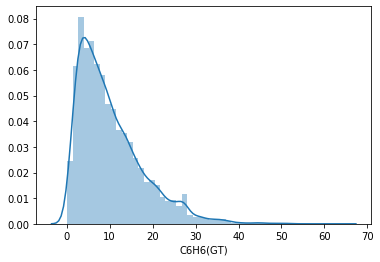

In [18]:
sns.distplot(dfc["C6H6(GT)"])

### Distribution Of T

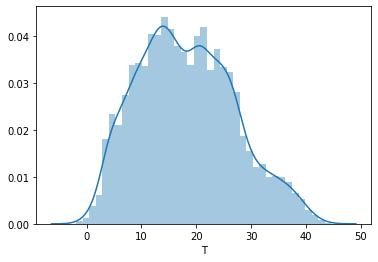

In [19]:
sns.distplot(dfc["T"])

### Distribution Of RH

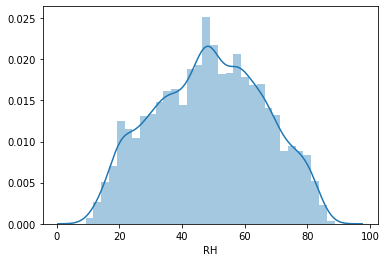

In [20]:
sns.distplot(dfc["RH"])

### Distribution Of AH

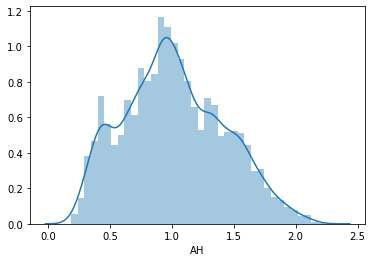

In [21]:
sns.distplot(dfc["AH"])

### Visualizing The Dependencies Of Variables

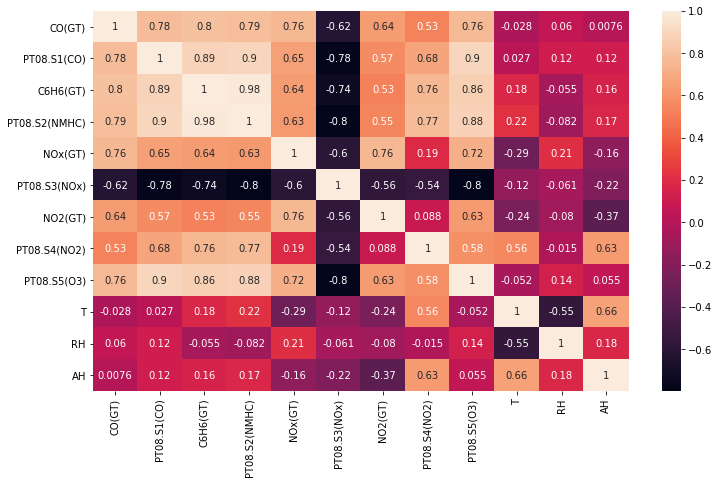

In [22]:
plt.figure(figsize = (12, 7))
sns.heatmap(dfc.corr(), annot=True)

## Prediction

### Splitting the Dataset to X and Y Variable

In [23]:
x = dfc.drop(['AH', 'Date', 'DateTime'], axis = 1)
y = dfc[['AH']]
print('Shape of X:', x.shape)
print('Shape of Y:', y.shape)

Shape of X: (9357, 11)
Shape of Y: (9357, 1)


### Splitting Into Train and Test

In [24]:
n = len(dfc)
x_train_df = x[0:int(n*0.8)]
x_test_df = x[int(n*0.8):]
y_train_df = y[0:int(n*0.8)]
y_test_df = y[int(n*0.8):]

In [25]:
print('Shape of x_train and x_test:', x_train_df.shape, x_test_df.shape)
print('Shape of y_train and y_test:', y_train_df.shape, y_test_df.shape)

Shape of x_train and x_test: (7485, 11) (1872, 11)
Shape of y_train and y_test: (7485, 1) (1872, 1)


### Scaling The Data

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_df)
x_test = scaler.fit_transform(x_test_df)

y_train = scaler.fit_transform(y_train_df)
y_test = scaler.fit_transform(y_test_df)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print('Shape of x_train and x_test:', x_train.shape, x_test.shape)
print('Shape of y_train and y_test:', y_train.shape, y_test.shape)

Shape of x_train and x_test: (7485, 11, 1) (1872, 11, 1)
Shape of y_train and y_test: (7485, 1) (1872, 1)


### Building The Model

In [27]:
def RNN_MODEL():
    # have to convert to 3D for feeding the data
    regressor = Sequential()
    regressor.add(LSTM(units = 50,return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50,return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    return regressor

### Running The Model

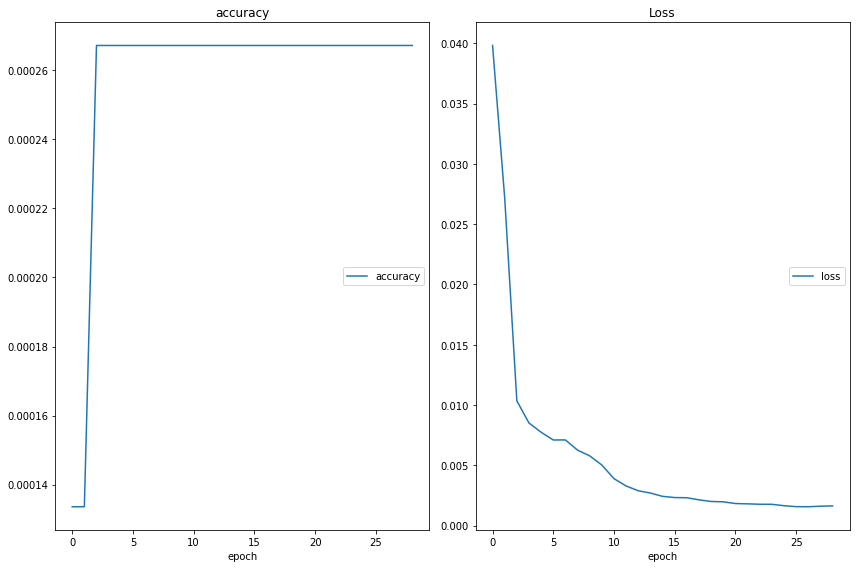

accuracy
	accuracy         	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss             	 (min:    0.002, max:    0.040, cur:    0.002)
234/234 [==============================] - 4s 17ms/step - loss: 0.0016 - accuracy: 2.6720e-04
Epoch 00029: early stopping


In [28]:
es = EarlyStopping(monitor = 'loss', mode = 'auto', patience = 2, verbose = 1)
cb = [PlotLossesKeras(), es]

regressor = RNN_MODEL()
regressor.fit(x_train, y_train, epochs = 100, callbacks = cb)

### Evaluating Our Model

In [29]:
regressor.evaluate(x_test,y_test)
y_pred = regressor.predict(x_test)
output = scaler.inverse_transform(y_pred)
real_output = []
for item in output:
    real_output.append((item[0]))

59/59 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.0011


### Plotting The y_test With Predicted

/Users/nmims/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


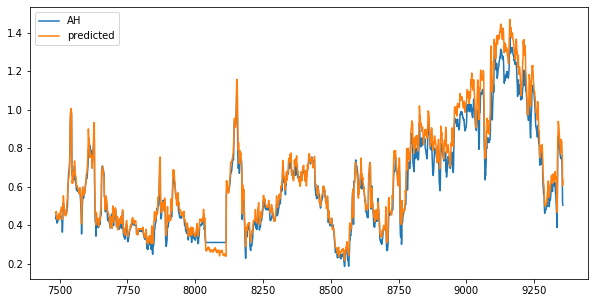

In [30]:
value = y_test_df
value['predicted'] = np.array(real_output)

plt.rcParams["figure.figsize"] = (10,5)
value.plot()